<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Трансформеры принятия решений и заключение**
___

*Задача: провести эксперименты с алгоритмами автономного обучения с подкреплением в среде Pogema.*
___

Описание

- Настройка среды. Использовать предложенную конфигурацию:

      grid_config = GridConfig(num_agents=1,  # number of agents
                            size=15, # size of the grid
                            density=0.4,  # obstacle density
                            seed=2,  # set to None for random
                                    # obstacles, agents and targets
                                    # positions at each reset
                            max_episode_steps=128,  # horizon
                            obs_radius=5,  # defines field of view
                            )
- Улучшение сходимости алгоритма:

  *   Добавьте wrapper, который будет выдавать агенту плотную награду за выполнение действий. К примеру пропорциональную изменению расстоянию от агента до цели.
  Исследование алгоритмов на данных с оптимальной стратегией:

  *   Использовать датасет с оптимальной стратегией поведения, полученной путем обучения online RL алгоритма.
  Обучить агентов, используя алгоритмы CQL и DT из фреймворка d3rlpy.

  *  Сравнить результаты с алгоритмом BC.


- Работа с субоптимальной стратегией:

  *  Сгенерировать датасет с субоптимальной стратегией с использованием библиотеки d3rlpy: добавить в датасет с хорошей стратегией обучения данные со случайной стратегией обучения.

  *  Обучить агентов, используя алгоритмы CQL и DT из фреймворка d3rlpy.
  *  Сравнить результаты с алгоритмом BC.

- Что нужно сдать:
  *  Код обучения в формате Jupyter.
  *  Графики сходимости (среднее вознаграждение) для всех исследованных алгоритмов.
  *  Выводы по используемым по обучению агента на оптимальных и неоптимальных данных.

# pip

In [1]:
!pip install pogema -q
!pip install d3rlpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 58.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.1 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.1 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata

In [13]:
!apt-get install -y xvfb ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay pygame moviepy > /dev/null 2>&1

# Pogema

Берем базовый врапер из семинара

`from pogema_example.ipynb`

  - Pogema — это мультиагентная среда, в которой несколько агентов в лабиринте должны достичь своих целей, причем каждый — своей. В любой момент времени у агента есть ограниченная область видимости, радиус которой определен.

  - В рамках данной работы мы будем использовать упрощенную версию этой среды, где задействован только один агент и установлен большой радиус видимости — 5 клеток.


In [27]:
import numpy as np
import pandas as pd
import gym
from pogema import pogema_v0, GridConfig

class VectorObservationAndActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(VectorObservationAndActionWrapper, self).__init__(env)
        self.action_space = env.action_space
        obs_space = env.observation_space
        size = obs_space.shape
        new_size = 1*size[1]*size[2]
        self.observation_space = gym.spaces.Box(low=np.zeros((new_size)),
                                                high=np.ones((new_size)),
                                                shape = (new_size,),
                                                dtype=obs_space.dtype)


    def reset(self):
        observation, is_active = self.env.reset()
        return observation[0][0].flatten(), is_active  # Возвращает наблюдение как одномерный вектор

    def step(self, action):
        # Упаковка действия в массив
        obs, reward, trancated, terminated, info = self.env.step([action])

        # Распаковка наблюдения, награды и флага завершения
        return obs[0][0].flatten(), reward[0],  trancated[0], terminated[0], info[0]

# Определение конфигурации среды
grid_config = GridConfig(num_agents=1,  # количество агентов
                         size=15,  # размер сетки
                         density=0.4,  # плотность препятствий
                         seed=2,  # зерно для генерации
                         max_episode_steps=128,  # горизонт планирования
                         obs_radius=3,  # радиус видимости
                         )

# Создание среды и обертывание ее
env = pogema_v0(grid_config=grid_config)
env = VectorObservationAndActionWrapper(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(10):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done =  trancated | terminated
    print(f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}")
    if done:
        break


Начальное наблюдение в виде вектора: 49
Наблюдение: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: 0.0, Завершено: False
Наблюдение: [1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.], Награда: 0.0, За

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# MY_Reward

Добавляем свой реворд, который учитывает удаленнность от цели связывая удаленность с реворд

In [28]:
class MY_Reward(gym.Wrapper):
    def __init__(self, env):
        super(MY_Reward, self).__init__(env)

    def step(self, action):
        obs, reward, truncated, terminated, info = self.env.step(action)
        target_coord = np.array(env.get_targets_xy())
        agent_coord =  np.array(env.get_agents_xy())
        distance_to_target = np.linalg.norm(agent_coord[0] - target_coord[0])
        reward -=0.1*distance_to_target

        return  obs, reward, truncated, terminated, info

    def reset(self):
        """Reset the environment and return the initial observation."""
        return self.env.reset()

env = MY_Reward(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(3):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done =  trancated | terminated
    env.render()
    print(f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}, Положение агента {env.get_agents_xy()}, Положение цели {env.get_targets_xy()}, action {action}")
    if done:
        break

Начальное наблюдение в виде вектора: 49
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 


# Функции отрисовки данных

Также берем из семинара

In [29]:
import matplotlib.pyplot as plt


def plot_metrics(statistics, label):
  epochs = []
  returns = []
  for stats in statistics:
    epoch = stats[0]
    metrics = stats[1]
    env_return = metrics['environment']
    epochs.append(epoch)
    returns.append(env_return)
  plt.plot(epochs, returns, label = label)


def get_scores(data):
  result = []
  for i in range(len(data)):
    result.append([scores[1]['environment'] for scores in data[i]])
  return np.array(result)

def visualize_with_std(data, proportions, label="default"):
  # Расчет средних значений и стандартных отклоненийt
  means = {p: np.mean(get_scores(data[p]), axis=0) for p in proportions}
  stds = {p: np.std(get_scores(data[p]), axis=0) for p in proportions}


  for p in proportions:
      x = np.arange(1, len(means[p]) + 1)
      plt.plot(x, means[p], label=f'{label} - Mean of {p}')
      plt.fill_between(x, means[p] - stds[p], means[p] + stds[p], alpha=0.2)

  plt.title('Сравнение обучения на данных разного качества')

# Обучение для сбора эталонных данных

учим как в семинаре было

In [30]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
import d3rlpy
# setup algorithm
dqn = d3rlpy.algos.DQNConfig().create(device=DEVICE.type)

# prepare experience replay buffer
dqn_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# prepare exploration strategy if necessary
explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.4)

# start data collection
dqn.fit_online(env, dqn_buffer, explorer, n_steps=150000, n_steps_per_epoch=5000)


2024-04-15 13:15.32 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-15 13:15.32 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-15 13:15.32 [info     ] Action size has been automatically determined. action_size=5
2024-04-15 13:15.32 [info     ] Directory is created at d3rlpy_logs/DQN_online_20240415131532
2024-04-15 13:15.32 [debug    ] Building model...             
2024-04-15 13:15.32 [debug    ] Model has been built.         
2024-04-15 13:15.32 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}

  0%|          | 0/150000 [00:00<?, ?it/s]

2024-04-15 13:16.04 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240415131532/model_5000.d3
2024-04-15 13:16.04 [info     ] DQN_online_20240415131532: epoch=1 step=5000 epoch=1 metrics={'time_inference': 0.0007315298557281494, 'time_environment_step': 0.00015617074966430664, 'time_step': 0.006333316993713379, 'time_sample_batch': 0.0016174371606847134, 'time_algorithm_update': 0.003750235928312163, 'loss': 0.0020799092803498575, 'rollout_return': -29.759409198219434} step=5000
2024-04-15 13:16.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240415131532/model_10000.d3
2024-04-15 13:16.37 [info     ] DQN_online_20240415131532: epoch=2 step=10000 epoch=2 metrics={'time_inference': 0.0007345747947692872, 'time_environment_step': 0.00015931496620178224, 'time_sample_batch': 0.0016792395114898682, 'time_algorithm_update': 0.0037971654415130617, 'loss': 0.00047712640929277434, 'time_step': 0.006515698337554931, 'rollout_return': -17.32768644819647}

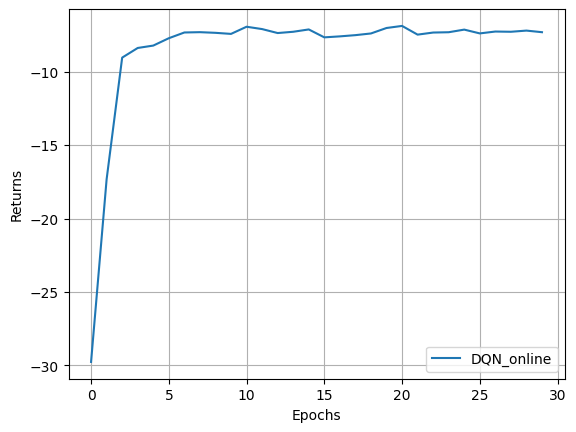

In [32]:
import pandas as pd
rollout_file = "/content/d3rlpy_logs/DQN_online_20240415131532/rollout_return.csv"
dt_statistics = pd.read_csv(rollout_file , header=None)

plt.plot(dt_statistics[2], label="DQN_online")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

In [33]:
from gym.wrappers import RecordVideo

# start virtual display
d3rlpy.notebook_utils.start_virtual_display()

# Создание среды и обертывание ее
env = pogema_v0(grid_config=grid_config, render_mode="rgb_array")
env = VectorObservationAndActionWrapper(env)
env = MY_Reward(env)
# wrap RecordVideo wrapper
env_v = RecordVideo(env, './video')

# Тестирование среды
obs = env.reset()

# evaluate
d3rlpy.metrics.evaluate_qlearning_with_environment(dqn, env_v)

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <MY_Reward<VectorObservationAndActionWrapper<EpLengthMetric<CSRMetric<ISRMetric<MultiTimeLimit<Pogema instance>>>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  .  .        .        

-3.3950335179817124

## Train Behavior Cloning (BC)

Учим на экспертных данных из rollout

- https://d3rlpy.readthedocs.io/en/v0.60/references/generated/d3rlpy.algos.DiscreteBC.html

Behavior Cloning algorithm for discrete control.

Behavior Cloning (BC) is to imitate actions in the dataset via a supervised learning approach. Since BC is only imitating action distributions, the performance will be close to the mean of the dataset even though BC mostly works better than online RL algorithms.


In [34]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=1e-4, gamma=0.9).create(device=DEVICE.type)

# start training
stat_bc = bc.fit(
    dqn_buffer,
    n_steps=100000,
    n_steps_per_epoch=7000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-15 13:34.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 13:34.46 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240415133446
2024-04-15 13:34.46 [debug    ] Building models...            
2024-04-15 13:34.46 [debug    ] Models have been built.       
2024-04-15 13:34.46 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0

Epoch 1/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:35.52 [info     ] DiscreteBC_20240415133446: epoch=1 step=7000 epoch=1 metrics={'time_sample_batch': 0.006195198229381017, 'time_algorithm_update': 0.003000760044370379, 'loss': 2.7359462155614582, 'time_step': 0.009284254005977086, 'environment': -3.3950335179817124} step=7000
2024-04-15 13:35.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_7000.d3


Epoch 2/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:36.58 [info     ] DiscreteBC_20240415133446: epoch=2 step=14000 epoch=2 metrics={'time_sample_batch': 0.0062360367093767435, 'time_algorithm_update': 0.0030137213638850623, 'loss': 2.734353866815567, 'time_step': 0.00934014538356236, 'environment': -3.3950335179817124} step=14000
2024-04-15 13:36.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_14000.d3


Epoch 3/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:38.04 [info     ] DiscreteBC_20240415133446: epoch=3 step=21000 epoch=3 metrics={'time_sample_batch': 0.0061656907285962785, 'time_algorithm_update': 0.0030195348603384835, 'loss': 2.7345077212538036, 'time_step': 0.00927508762904576, 'environment': -3.3950335179817124} step=21000
2024-04-15 13:38.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_21000.d3


Epoch 4/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:39.10 [info     ] DiscreteBC_20240415133446: epoch=4 step=28000 epoch=4 metrics={'time_sample_batch': 0.006190076317105974, 'time_algorithm_update': 0.00302417870930263, 'loss': 2.7343057686941963, 'time_step': 0.009303146873201643, 'environment': -3.3950335179817124} step=28000
2024-04-15 13:39.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_28000.d3


Epoch 5/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:40.16 [info     ] DiscreteBC_20240415133446: epoch=5 step=35000 epoch=5 metrics={'time_sample_batch': 0.006203713076455252, 'time_algorithm_update': 0.003037440470286778, 'loss': 2.734542879274913, 'time_step': 0.009332242046083723, 'environment': -3.3950335179817124} step=35000
2024-04-15 13:40.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_35000.d3


Epoch 6/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:41.23 [info     ] DiscreteBC_20240415133446: epoch=6 step=42000 epoch=6 metrics={'time_sample_batch': 0.006282132455280849, 'time_algorithm_update': 0.0030694372653961182, 'loss': 2.7343062109606606, 'time_step': 0.009441571405955723, 'environment': -3.3950335179817124} step=42000
2024-04-15 13:41.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_42000.d3


Epoch 7/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:42.30 [info     ] DiscreteBC_20240415133446: epoch=7 step=49000 epoch=7 metrics={'time_sample_batch': 0.006212840625217982, 'time_algorithm_update': 0.003068638631275722, 'loss': 2.7346081755161284, 'time_step': 0.009372576645442417, 'environment': -3.3950335179817124} step=49000
2024-04-15 13:42.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_49000.d3


Epoch 8/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:43.36 [info     ] DiscreteBC_20240415133446: epoch=8 step=56000 epoch=8 metrics={'time_sample_batch': 0.006207874400275094, 'time_algorithm_update': 0.00306335711479187, 'loss': 2.734474240439279, 'time_step': 0.009360291651317052, 'environment': -3.3950335179817124} step=56000
2024-04-15 13:43.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_56000.d3


Epoch 9/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:44.43 [info     ] DiscreteBC_20240415133446: epoch=9 step=63000 epoch=9 metrics={'time_sample_batch': 0.00627861213684082, 'time_algorithm_update': 0.0030749295779636926, 'loss': 2.733794778381075, 'time_step': 0.009443071433476039, 'environment': -3.3950335179817124} step=63000
2024-04-15 13:44.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_63000.d3


Epoch 10/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:45.50 [info     ] DiscreteBC_20240415133446: epoch=10 step=70000 epoch=10 metrics={'time_sample_batch': 0.006228471040725708, 'time_algorithm_update': 0.0030950437273297993, 'loss': 2.733848106963294, 'time_step': 0.009413548231124879, 'environment': -3.3950335179817124} step=70000
2024-04-15 13:45.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_70000.d3


Epoch 11/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:46.56 [info     ] DiscreteBC_20240415133446: epoch=11 step=77000 epoch=11 metrics={'time_sample_batch': 0.006207671233585903, 'time_algorithm_update': 0.0030783252375466484, 'loss': 2.7332704963343484, 'time_step': 0.009377152136393957, 'environment': -3.3950335179817124} step=77000
2024-04-15 13:46.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_77000.d3


Epoch 12/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:48.03 [info     ] DiscreteBC_20240415133446: epoch=12 step=84000 epoch=12 metrics={'time_sample_batch': 0.006260595594133649, 'time_algorithm_update': 0.0031139435427529473, 'loss': 2.734620579617364, 'time_step': 0.009464208739144461, 'environment': -3.3950335179817124} step=84000
2024-04-15 13:48.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_84000.d3


Epoch 13/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:49.10 [info     ] DiscreteBC_20240415133446: epoch=13 step=91000 epoch=13 metrics={'time_sample_batch': 0.006224050215312413, 'time_algorithm_update': 0.003087727001735142, 'loss': 2.734421004499708, 'time_step': 0.009402892453329904, 'environment': -3.3950335179817124} step=91000
2024-04-15 13:49.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_91000.d3


Epoch 14/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 13:50.17 [info     ] DiscreteBC_20240415133446: epoch=14 step=98000 epoch=14 metrics={'time_sample_batch': 0.006242573431559971, 'time_algorithm_update': 0.0030973301615033833, 'loss': 2.7342622218132018, 'time_step': 0.009433164187840053, 'environment': -3.3950335179817124} step=98000
2024-04-15 13:50.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415133446/model_98000.d3


In [35]:
test_episodes = 1
total_rewards = 0

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = bc.predict(observation)[0]
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

##  Train CQL

Discrete version of Conservative Q-Learning algorithm.

Discrete version of CQL is a DoubleDQN-based data-driven deep reinforcement learning algorithm (the original paper uses DQN), which achieves state-of-the-art performance in offline RL problems.

https://d3rlpy.readthedocs.io/en/v0.60/references/generated/d3rlpy.algos.DiscreteCQL.html?highlight=d3rlpy.algos

In [36]:
cql = d3rlpy.algos.DiscreteCQLConfig(learning_rate=1e-4, gamma=0.9).create(device=DEVICE.type)

# start training
stat_cql = cql.fit(
    dqn_buffer,
    n_steps=50000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-15 13:53.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 13:53.27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240415135327
2024-04-15 13:53.27 [debug    ] Building models...            
2024-04-15 13:53.27 [debug    ] Models have been built.       
2024-04-15 13:53.27 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:54.06 [info     ] DiscreteCQL_20240415135327: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0022540796279907228, 'time_algorithm_update': 0.00536713376045227, 'loss': 1.3219332341432573, 'td_loss': 0.11360790080428124, 'conservative_loss': 1.2083253331899644, 'time_step': 0.007742938137054444, 'environment': -3.3950335179817124} step=5000
2024-04-15 13:54.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:54.46 [info     ] DiscreteCQL_20240415135327: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.002211829137802124, 'time_algorithm_update': 0.005366687774658203, 'loss': 1.3084094408750535, 'td_loss': 0.11443232550024986, 'conservative_loss': 1.1939771155714989, 'time_step': 0.007699418306350708, 'environment': -3.3950335179817124} step=10000
2024-04-15 13:54.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:55.25 [info     ] DiscreteCQL_20240415135327: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.0022633619308471678, 'time_algorithm_update': 0.005431698036193848, 'loss': 1.3019601848483087, 'td_loss': 0.11041891357302666, 'conservative_loss': 1.1915412714362144, 'time_step': 0.007817184114456177, 'environment': -3.3950335179817124} step=15000
2024-04-15 13:55.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:56.05 [info     ] DiscreteCQL_20240415135327: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0022604820728302, 'time_algorithm_update': 0.005428113603591919, 'loss': 1.2933277558803558, 'td_loss': 0.10634346138238907, 'conservative_loss': 1.1869842939138413, 'time_step': 0.007817395448684693, 'environment': -3.3950335179817124} step=20000
2024-04-15 13:56.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:56.44 [info     ] DiscreteCQL_20240415135327: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.002240139675140381, 'time_algorithm_update': 0.005383579921722412, 'loss': 1.2886282378911973, 'td_loss': 0.10477546005025506, 'conservative_loss': 1.1838527778744699, 'time_step': 0.007744342470169067, 'environment': -3.3950335179817124} step=25000
2024-04-15 13:56.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:57.24 [info     ] DiscreteCQL_20240415135327: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0022445364952087404, 'time_algorithm_update': 0.005375901174545288, 'loss': 1.2816676493883132, 'td_loss': 0.1014628599718213, 'conservative_loss': 1.180204789662361, 'time_step': 0.007740783166885376, 'environment': -3.3950335179817124} step=30000
2024-04-15 13:57.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:58.03 [info     ] DiscreteCQL_20240415135327: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0022559545993804933, 'time_algorithm_update': 0.005408310317993164, 'loss': 1.284362183368206, 'td_loss': 0.10045796527937055, 'conservative_loss': 1.1839042185544968, 'time_step': 0.007793396425247193, 'environment': -3.3950335179817124} step=35000
2024-04-15 13:58.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:58.43 [info     ] DiscreteCQL_20240415135327: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0022288373947143554, 'time_algorithm_update': 0.005377359294891358, 'loss': 1.279569867527485, 'td_loss': 0.10092877542003989, 'conservative_loss': 1.1786410919070245, 'time_step': 0.007724377679824829, 'environment': -3.3950335179817124} step=40000
2024-04-15 13:58.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 13:59.22 [info     ] DiscreteCQL_20240415135327: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0022835731983184815, 'time_algorithm_update': 0.005441452074050904, 'loss': 1.2745892795443534, 'td_loss': 0.09849563704803586, 'conservative_loss': 1.1760936417460441, 'time_step': 0.007859059095382691, 'environment': -3.3950335179817124} step=45000
2024-04-15 13:59.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 14:00.03 [info     ] DiscreteCQL_20240415135327: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0023195507526397705, 'time_algorithm_update': 0.005515146541595459, 'loss': 1.275546482861042, 'td_loss': 0.0976318257637322, 'conservative_loss': 1.1779146563053131, 'time_step': 0.007968734502792358, 'environment': -3.3950335179817124} step=50000
2024-04-15 14:00.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415135327/model_50000.d3


In [37]:
test_episodes = 1
total_rewards = 0

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = cql.predict(observation)[0]
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

Все ОК, сходится!

## Train DecisionTransformer

https://d3rlpy.readthedocs.io/en/v2.3.0/references/algos.html#decisiontransformer

Для перевода распределения вероятностей в действие, применяем `SoftmaxTransformerActionSampler`

In [38]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device=DEVICE.type)

# offline training
dt.fit(
   dqn_buffer,
   n_steps=50000,
   n_steps_per_epoch=5000,
   eval_env=env,
   eval_target_return=0,
   # from probability get action by SoftmaxTransformerActionSampler
   eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-15 14:19.07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 14:19.07 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240415141907
2024-04-15 14:19.07 [debug    ] Building models...            
2024-04-15 14:19.07 [debug    ] Models have been built.       
2024-04-15 14:19.07 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'learnin

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 14:28.10 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.01558458857536316, 'time_algorithm_update': 0.09134052562713622, 'loss': 0.570394196331501, 'learning_rate': 0.0005735547795140118, 'time_step': 0.10706965961456298, 'environment': -10.47337213629602} step=5000
2024-04-15 14:28.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 14:37.12 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.01566355347633362, 'time_algorithm_update': 0.09119601221084594, 'loss': 0.48244425939321517, 'learning_rate': 0.00043320793368811, 'time_step': 0.10700353941917419, 'environment': -5.102077523610989} step=10000
2024-04-15 14:37.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 14:46.17 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.01565616660118103, 'time_algorithm_update': 0.09120745453834533, 'loss': 0.42559460100531576, 'learning_rate': 0.00022379687242975868, 'time_step': 0.10701114888191224, 'environment': -37.325519523843525} step=15000
2024-04-15 14:46.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 14:55.23 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.01578322892189026, 'time_algorithm_update': 0.09129235606193542, 'loss': 0.39669404457211493, 'learning_rate': 7.222904577003406e-05, 'time_step': 0.10723629612922668, 'environment': -30.132831535523007} step=20000
2024-04-15 14:55.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:04.28 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.01572876181602478, 'time_algorithm_update': 0.09125080952644349, 'loss': 0.38736851288080215, 'learning_rate': 6.000000000000334e-05, 'time_step': 0.10711805000305176, 'environment': -23.167511240665178} step=25000
2024-04-15 15:04.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:13.36 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.01584676856994629, 'time_algorithm_update': 0.09131495151519775, 'loss': 0.3848238462924957, 'learning_rate': 0.00011765389018669911, 'time_step': 0.10733463912010192, 'environment': -44.0215009971279} step=30000
2024-04-15 15:13.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:22.46 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.015832845306396483, 'time_algorithm_update': 0.09129549851417541, 'loss': 0.3935551344871521, 'learning_rate': 0.0003164816127706349, 'time_step': 0.10728074526786804, 'environment': -61.621455214631695} step=35000
2024-04-15 15:22.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:31.52 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.01576920437812805, 'time_algorithm_update': 0.09129702849388123, 'loss': 0.39199184991121294, 'learning_rate': 0.0005083332997791338, 'time_step': 0.10721755428314209, 'environment': -27.09889013365528} step=40000
2024-04-15 15:31.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:40.56 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.01572065725326538, 'time_algorithm_update': 0.09123612089157104, 'loss': 0.3805895877897739, 'learning_rate': 0.0005929812760132971, 'time_step': 0.10709662771224976, 'environment': -18.24878728096757} step=45000
2024-04-15 15:40.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 15:50.02 [info     ] DiscreteDecisionTransformer_20240415141907: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.015732328987121583, 'time_algorithm_update': 0.09126982731819153, 'loss': 0.35553927570581434, 'learning_rate': 0.0005269430323320698, 'time_step': 0.10715361671447754, 'environment': -33.720580917064034} step=50000
2024-04-15 15:50.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/model_50000.d3


In [54]:
test_episodes = 1
total_rewards = 0

# wrap as stateful actor for interaction
actor = dt.as_stateful_wrapper(target_return=0)

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = actor.predict(observation, 0)
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

Я поставил мало шагов обучении

НО ДОХОДИТ В ИТОГЕ!


## Summary

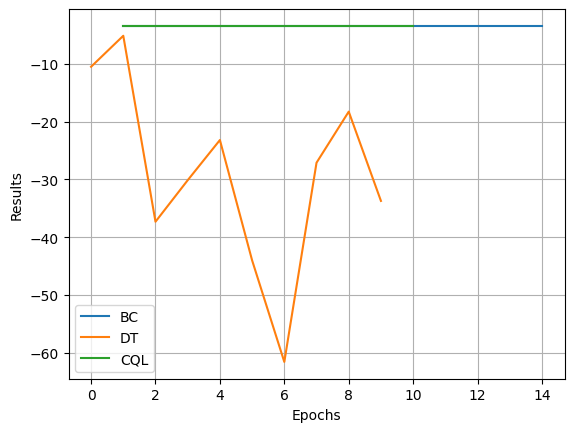

In [55]:
dt_stat = pd.read_csv('/content/d3rlpy_logs/DiscreteDecisionTransformer_20240415141907/environment.csv', header=None)[2]

plot_metrics(stat_bc, "BC")
plt.plot(dt_stat, label="DT")
plot_metrics(stat_cql, "CQL")
plt.xlabel("Epochs")
plt.ylabel("Results")
plt.legend()
plt.grid()

DT учится медлено и хочется уже его выключить!
Но по итогу видно, что доходит

Для такой задачи можно ставить на много меньше шагов!

BC и CQL учатся быстро, выходя на максимум

# Учим на смешанных данных

## Готовим данные на случайной стратегии

https://d3rlpy.readthedocs.io/en/v2.3.0/_modules/d3rlpy/algos/qlearning/random_policy.html?highlight=d3rlpy.algos.qlearning.random_policy

In [56]:
# setup algorithm
random_policy = d3rlpy.algos.DiscreteRandomPolicyConfig().create()

# prepare experience replay buffer
random_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# start data collection
random_policy.collect(env, random_buffer, n_steps=100000)

2024-04-15 16:33.03 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-15 16:33.03 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-15 16:33.03 [info     ] Action size has been automatically determined. action_size=5
2024-04-15 16:33.03 [debug    ] Building model...             
2024-04-15 16:33.03 [debug    ] Model has been built.         


  0%|          | 0/100000 [00:00<?, ?it/s]

Как будет менятся обучение агента на смешанной стратегии (часть данных экспертные - чать случайные)?

Смешиванм 70% экспертные  и 30% случайные

In [58]:
def dataset_with_terminals(buffer, size):
  observations = []
  actions = []
  rewards = []
  terminals = []

  for episode in buffer.episodes[:size]:
    observations+=episode.observations.tolist()
    actions += episode.actions.tolist()
    rewards += episode.rewards.tolist()

    terminal = [0 for _ in range(len(episode.rewards))]
    terminal[-1] = 1
    terminals += terminal
  return observations, actions, rewards, terminals

def make_mixed_dataset(dataset_1, dataset_2, proportions = [1,1]):
  size_1 = int(len(dataset_1.episodes) * proportions[0])
  size_2 = int(len(dataset_2.episodes) * proportions[1])

  observations, actions, rewards, terminals = dataset_with_terminals(dataset_1, size_1)
  rnd_observations, rnd_actions, rnd_rewards, rnd_terminals = dataset_with_terminals(dataset_2, size_2)

  mxt_obs = np.asarray(observations+rnd_observations)
  mxt_actions = np.asarray(actions+rnd_actions)
  mxt_rewards = np.asarray(rewards+rnd_rewards)
  mxt_terminals = np.asarray(terminals+rnd_terminals).reshape(-1,1)

  mixed_dataset = d3rlpy.dataset.MDPDataset(
    observations=mxt_obs,
    actions=mxt_actions,
    rewards=mxt_rewards,
    terminals=mxt_terminals,
  )
  return mixed_dataset


mixed_data = make_mixed_dataset(dqn_buffer, random_buffer, (0.7, 0.3))

2024-04-15 16:42.31 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-04-15 16:42.31 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-15 16:42.31 [info     ] Action size has been automatically determined. action_size=5


## Train BC на смешанных

In [59]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=1e-4, gamma=0.9).create(device=DEVICE.type)

# start training
mexed_bc = bc.fit(
    mixed_data,
    n_steps=100000,
    n_steps_per_epoch=7000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-15 16:42.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 16:42.49 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240415164249
2024-04-15 16:42.49 [debug    ] Building models...            
2024-04-15 16:42.49 [debug    ] Models have been built.       
2024-04-15 16:42.49 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9

Epoch 1/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:43.43 [info     ] DiscreteBC_20240415164249: epoch=1 step=7000 epoch=1 metrics={'time_sample_batch': 0.00459696102142334, 'time_algorithm_update': 0.003037895475115095, 'loss': 2.808333229439599, 'time_step': 0.00772481792313712, 'environment': -3.3950335179817124} step=7000
2024-04-15 16:43.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_7000.d3


Epoch 2/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:44.39 [info     ] DiscreteBC_20240415164249: epoch=2 step=14000 epoch=2 metrics={'time_sample_batch': 0.004619661569595337, 'time_algorithm_update': 0.0030814905847821915, 'loss': 2.807321285384042, 'time_step': 0.007792481899261475, 'environment': -3.3950335179817124} step=14000
2024-04-15 16:44.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_14000.d3


Epoch 3/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:45.34 [info     ] DiscreteBC_20240415164249: epoch=3 step=21000 epoch=3 metrics={'time_sample_batch': 0.004572082383292062, 'time_algorithm_update': 0.003063077517918178, 'loss': 2.8066950678825378, 'time_step': 0.007725033623831612, 'environment': -3.3950335179817124} step=21000
2024-04-15 16:45.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_21000.d3


Epoch 4/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:46.30 [info     ] DiscreteBC_20240415164249: epoch=4 step=28000 epoch=4 metrics={'time_sample_batch': 0.004677611759730748, 'time_algorithm_update': 0.003111623866217477, 'loss': 2.806978319168091, 'time_step': 0.007882165431976318, 'environment': -3.3950335179817124} step=28000
2024-04-15 16:46.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_28000.d3


Epoch 5/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:47.25 [info     ] DiscreteBC_20240415164249: epoch=5 step=35000 epoch=5 metrics={'time_sample_batch': 0.004588034629821778, 'time_algorithm_update': 0.003076493671962193, 'loss': 2.8069253086362567, 'time_step': 0.007755715267998831, 'environment': -3.3950335179817124} step=35000
2024-04-15 16:47.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_35000.d3


Epoch 6/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:48.20 [info     ] DiscreteBC_20240415164249: epoch=6 step=42000 epoch=6 metrics={'time_sample_batch': 0.004562632867268154, 'time_algorithm_update': 0.0030823267868586948, 'loss': 2.8064212643078394, 'time_step': 0.007735849823270525, 'environment': -3.3950335179817124} step=42000
2024-04-15 16:48.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_42000.d3


Epoch 7/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:49.15 [info     ] DiscreteBC_20240415164249: epoch=7 step=49000 epoch=7 metrics={'time_sample_batch': 0.004576731477464948, 'time_algorithm_update': 0.0031085872990744457, 'loss': 2.806807653393064, 'time_step': 0.0077732608999524794, 'environment': -3.3950335179817124} step=49000
2024-04-15 16:49.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_49000.d3


Epoch 8/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:50.10 [info     ] DiscreteBC_20240415164249: epoch=8 step=56000 epoch=8 metrics={'time_sample_batch': 0.004527086496353149, 'time_algorithm_update': 0.0030984833240509033, 'loss': 2.8067320349216462, 'time_step': 0.007713237353733608, 'environment': -3.3950335179817124} step=56000
2024-04-15 16:50.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_56000.d3


Epoch 9/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:51.04 [info     ] DiscreteBC_20240415164249: epoch=9 step=63000 epoch=9 metrics={'time_sample_batch': 0.0044897020203726636, 'time_algorithm_update': 0.0030779091290065222, 'loss': 2.8063172190189363, 'time_step': 0.007655307974134173, 'environment': -3.3950335179817124} step=63000
2024-04-15 16:51.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_63000.d3


Epoch 10/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:51.59 [info     ] DiscreteBC_20240415164249: epoch=10 step=70000 epoch=10 metrics={'time_sample_batch': 0.004580306734357561, 'time_algorithm_update': 0.003117844547544207, 'loss': 2.8069561408587864, 'time_step': 0.007786344187600272, 'environment': -3.3950335179817124} step=70000
2024-04-15 16:51.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_70000.d3


Epoch 11/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:52.54 [info     ] DiscreteBC_20240415164249: epoch=11 step=77000 epoch=11 metrics={'time_sample_batch': 0.004508447340556553, 'time_algorithm_update': 0.0030976613930293493, 'loss': 2.807095240252359, 'time_step': 0.007691955668585641, 'environment': -3.3950335179817124} step=77000
2024-04-15 16:52.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_77000.d3


Epoch 12/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:53.49 [info     ] DiscreteBC_20240415164249: epoch=12 step=84000 epoch=12 metrics={'time_sample_batch': 0.004523119824273246, 'time_algorithm_update': 0.0031025255407605853, 'loss': 2.8065117221900393, 'time_step': 0.007711363860539028, 'environment': -3.3950335179817124} step=84000
2024-04-15 16:53.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_84000.d3


Epoch 13/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:54.44 [info     ] DiscreteBC_20240415164249: epoch=13 step=91000 epoch=13 metrics={'time_sample_batch': 0.004598189898899623, 'time_algorithm_update': 0.003132124696459089, 'loss': 2.8064624122892106, 'time_step': 0.007818284681865148, 'environment': -3.3950335179817124} step=91000
2024-04-15 16:54.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_91000.d3


Epoch 14/14:   0%|          | 0/7000 [00:00<?, ?it/s]

2024-04-15 16:55.39 [info     ] DiscreteBC_20240415164249: epoch=14 step=98000 epoch=14 metrics={'time_sample_batch': 0.0045386507511138915, 'time_algorithm_update': 0.0031163198947906493, 'loss': 2.8071737187589916, 'time_step': 0.007745251962116786, 'environment': -3.3950335179817124} step=98000
2024-04-15 16:55.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240415164249/model_98000.d3


In [60]:
test_episodes = 1
total_rewards = 0

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = bc.predict(observation)[0]
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

## Train CQL на смешанных

In [61]:
cql = d3rlpy.algos.DiscreteCQLConfig(learning_rate=1e-4, gamma=0.9).create(device=DEVICE.type)

# start training
mixed_cql = cql.fit(
    mixed_data,
    n_steps=50000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-15 16:59.44 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 16:59.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240415165944
2024-04-15 16:59.44 [debug    ] Building models...            
2024-04-15 16:59.44 [debug    ] Models have been built.       
2024-04-15 16:59.44 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:00.20 [info     ] DiscreteCQL_20240415165944: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0016782313346862792, 'time_algorithm_update': 0.005406357431411743, 'loss': 1.4491583740472793, 'td_loss': 0.0661488217331469, 'conservative_loss': 1.3830095523118973, 'time_step': 0.007221399354934693, 'environment': -3.3950335179817124} step=5000
2024-04-15 17:00.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:00.58 [info     ] DiscreteCQL_20240415165944: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0017216280460357666, 'time_algorithm_update': 0.005478251075744629, 'loss': 1.4406812910556792, 'td_loss': 0.06638979833498597, 'conservative_loss': 1.3742914924383163, 'time_step': 0.007341684341430664, 'environment': -3.3950335179817124} step=10000
2024-04-15 17:00.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:01.36 [info     ] DiscreteCQL_20240415165944: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.001778784465789795, 'time_algorithm_update': 0.005586933088302612, 'loss': 1.4318004238367081, 'td_loss': 0.06210768174417317, 'conservative_loss': 1.3696927421808243, 'time_step': 0.007510319185256958, 'environment': -3.3950335179817124} step=15000
2024-04-15 17:01.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:02.13 [info     ] DiscreteCQL_20240415165944: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0017311800479888916, 'time_algorithm_update': 0.00546703143119812, 'loss': 1.4257640808582306, 'td_loss': 0.060952754322439434, 'conservative_loss': 1.3648113269329072, 'time_step': 0.007338496446609497, 'environment': -3.3950335179817124} step=20000
2024-04-15 17:02.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:02.50 [info     ] DiscreteCQL_20240415165944: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0017297874927520752, 'time_algorithm_update': 0.005494518947601318, 'loss': 1.4239783083438873, 'td_loss': 0.05859049008972943, 'conservative_loss': 1.3653878172636031, 'time_step': 0.007366879749298096, 'environment': -3.3950335179817124} step=25000
2024-04-15 17:02.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:03.28 [info     ] DiscreteCQL_20240415165944: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0017075093746185303, 'time_algorithm_update': 0.005461810541152954, 'loss': 1.4178755794525146, 'td_loss': 0.05658103767707944, 'conservative_loss': 1.3612945423126221, 'time_step': 0.007304855108261108, 'environment': -3.3950335179817124} step=30000
2024-04-15 17:03.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:04.04 [info     ] DiscreteCQL_20240415165944: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0016783174991607667, 'time_algorithm_update': 0.00544503870010376, 'loss': 1.4185487655162812, 'td_loss': 0.05696326802633703, 'conservative_loss': 1.3615854977369308, 'time_step': 0.007258632898330689, 'environment': -3.3950335179817124} step=35000
2024-04-15 17:04.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:04.42 [info     ] DiscreteCQL_20240415165944: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0017081525325775147, 'time_algorithm_update': 0.005468904161453247, 'loss': 1.4166602620363236, 'td_loss': 0.05718395272791386, 'conservative_loss': 1.3594763090133668, 'time_step': 0.00731546859741211, 'environment': -3.3950335179817124} step=40000
2024-04-15 17:04.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:05.19 [info     ] DiscreteCQL_20240415165944: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.001715320873260498, 'time_algorithm_update': 0.005477563381195068, 'loss': 1.4167406961917877, 'td_loss': 0.05643822682611644, 'conservative_loss': 1.3603024696707726, 'time_step': 0.007327331447601318, 'environment': -3.3950335179817124} step=45000
2024-04-15 17:05.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2024-04-15 17:05.56 [info     ] DiscreteCQL_20240415165944: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0016972484588623046, 'time_algorithm_update': 0.00548273344039917, 'loss': 1.41912373380661, 'td_loss': 0.05569543706029653, 'conservative_loss': 1.363428296840191, 'time_step': 0.007316540622711182, 'environment': -3.3950335179817124} step=50000
2024-04-15 17:05.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240415165944/model_50000.d3


In [62]:
test_episodes = 1
total_rewards = 0

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = cql.predict(observation)[0]
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

## Train DT на смешанных

In [63]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device=DEVICE.type)

# offline training
dt.fit(
   mixed_data,
   n_steps=10000,
   n_steps_per_epoch=1000,
   eval_env=env,
   eval_target_return=0,
   # from probability get action by SoftmaxTransformerActionSampler
   eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-15 17:11.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-15 17:11.00 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240415171100
2024-04-15 17:11.00 [debug    ] Building models...            
2024-04-15 17:11.00 [debug    ] Models have been built.       
2024-04-15 17:11.00 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'lear

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:12.48 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.013595303297042846, 'time_algorithm_update': 0.09216757869720459, 'loss': 0.8705868075489998, 'learning_rate': 0.0005969401066586931, 'time_step': 0.10590464401245117, 'environment': -3.951417601938826} step=1000
2024-04-15 17:12.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:14.37 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.013251221656799317, 'time_algorithm_update': 0.09208233952522278, 'loss': 0.8524574035406113, 'learning_rate': 0.0005891732541028005, 'time_step': 0.10544060516357422, 'environment': -6.677385447059254} step=2000
2024-04-15 17:14.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:16.25 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.01345189905166626, 'time_algorithm_update': 0.09193079042434692, 'loss': 0.8493387849926949, 'learning_rate': 0.0005708094183705968, 'time_step': 0.10549653148651122, 'environment': -5.240210007463567} step=3000
2024-04-15 17:16.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:18.18 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.013213347911834717, 'time_algorithm_update': 0.09177828598022461, 'loss': 0.8458226161599159, 'learning_rate': 0.0005439898118377161, 'time_step': 0.10509515070915222, 'environment': -48.32269091648639} step=4000
2024-04-15 17:18.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:20.08 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.013737091541290283, 'time_algorithm_update': 0.09190795063972473, 'loss': 0.8336596364974975, 'learning_rate': 0.0005095179856069773, 'time_step': 0.10576475524902344, 'environment': -14.891945945225922} step=5000
2024-04-15 17:20.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:22.00 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.01369571042060852, 'time_algorithm_update': 0.09188840246200561, 'loss': 0.818356336414814, 'learning_rate': 0.0004685032385349098, 'time_step': 0.10570071244239806, 'environment': -28.631873515026843} step=6000
2024-04-15 17:22.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:23.51 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.013645052194595338, 'time_algorithm_update': 0.09189905381202698, 'loss': 0.8057833214402199, 'learning_rate': 0.00042221900301990013, 'time_step': 0.10565703558921814, 'environment': -28.40952097002858} step=7000
2024-04-15 17:23.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:25.47 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.01381114411354065, 'time_algorithm_update': 0.09192169189453125, 'loss': 0.7928933154344558, 'learning_rate': 0.0003719888774919773, 'time_step': 0.10585360646247864, 'environment': -63.32722657694205} step=8000
2024-04-15 17:25.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:27.43 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.013681888580322266, 'time_algorithm_update': 0.09196858787536621, 'loss': 0.7731612550616265, 'learning_rate': 0.0003195057497489204, 'time_step': 0.10577958512306214, 'environment': -69.58500496099194} step=9000
2024-04-15 17:27.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-15 17:29.38 [info     ] DiscreteDecisionTransformer_20240415171100: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.01357073998451233, 'time_algorithm_update': 0.0920206708908081, 'loss': 0.7601218144893647, 'learning_rate': 0.0002664256632106206, 'time_step': 0.10570085549354553, 'environment': -56.09449797595386} step=10000
2024-04-15 17:29.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/model_10000.d3


In [64]:
test_episodes = 1
total_rewards = 0

# wrap as stateful actor for interaction
actor = dt.as_stateful_wrapper(target_return=0)

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = actor.predict(observation, 0)
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break

  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  .  .        .        

Я поставил совсем мало шагов обучении

НО ДОХОДИТ В ИТОГЕ!


## Summary

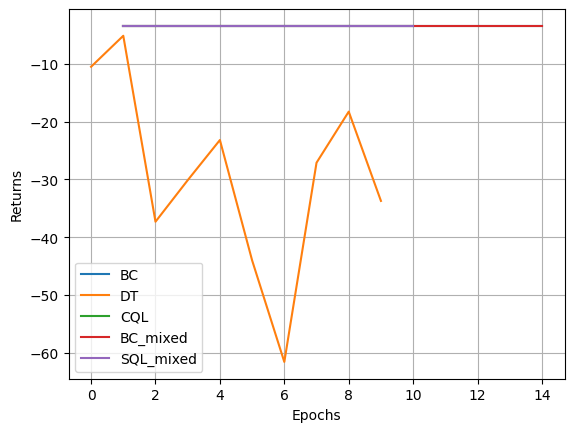

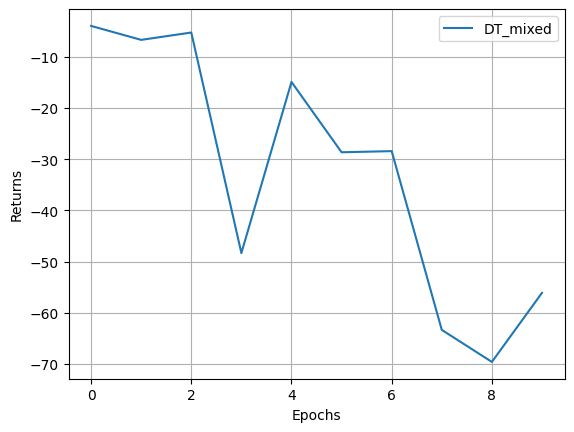

In [72]:
mixed_dt = pd.read_csv('/content/d3rlpy_logs/DiscreteDecisionTransformer_20240415171100/environment.csv', header=None)[2]

plot_metrics(stat_bc, "BC")
plt.plot(dt_stat, label="DT")
plot_metrics(stat_cql, "CQL")
plot_metrics(mexed_bc, "BC_mixed")
plot_metrics(mixed_cql, "SQL_mixed")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()
plt.show()

plt.plot(mixed_dt, label="DT_mixed")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()
plt.show()